# Overview

This notebook contains all code and discussions for the __expert iteration__ of the research question involving __lesion coloration (or appearance) and malignancy__. The specific research objective is to make a predictive model that can accurately classify new samples as benign/malignant lesions, based on the image. This is an advanced version of [this intermediate module](../intermediate/Q1.ipynb) revolving around the same features.

# Table of Contents

I. [Setup](#setup)

II. [Data Retrieval](#dr)

1. [File Access](#fa)
2. [Loading & Processing](#lp)

III. [Analysis](#anl)

1. [Compile Model Design](#ed)
2. [Train Model](#)
3. [History & Performance](#)
4. [Optional Multi-Class Step](#)

IV. [Discussion](#d)

# Setup

Refer to [this module](../novice/Data_Download.ipynb) for replicating the data-download process using the ISIC Python tool. The command is repeated below, although file/directory locations may need adjustment. 

`
python download_archive.py \
--num-images=50 \ 
--images-dir ../../sample_imgs \ 
--descs-dir ../../sample_dscs -s \ 
--seg-dir ../../sample_segs --seg-skill expert
`

The following are necessary imports for this module.

In [2]:
# data retrieval
import glob
import json
from PIL import Image
import cv2

# data manipulation, analysis, and visualization
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.models import Model
from keras.layers import Dense, MaxPooling2D, GlobalAveragePooling2D
from keras import Input
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Data Retrieval

# File Access

As in other modules, access the "targets" or response variables (benign/malignancy flags).

In [3]:
# getting file locations
dsc_filepaths = glob.glob('../../sample_dscs/*')
print('Descriptions: ', len(dsc_filepaths))

# extracting from json
dscs = [json.load(open(x, 'r'))['meta']['clinical'] for x in dsc_filepaths]
targets = [x['benign_malignant'] for x in dscs]

# sample output
for i in range(3):
    print('Data point #%d: %s' % (i, targets[i]))

Descriptions:  50
Data point #0: benign
Data point #1: benign
Data point #2: malignant


Initial access of the image files and corresponding segmentation is similar.

In [11]:
# check that file names match with description files
img_filepaths = glob.glob('../../sample_imgs/*')
seg_filepaths = glob.glob('../../sample_segs/*')

for i in range(3):
    print('Data point #%d, %s %s %s' % (i, dsc_filepaths[i], img_filepaths[i], seg_filepaths[i]))

Data point #0, ../../sample_dscs/ISIC_0000000 ../../sample_imgs/ISIC_0000000.jpeg ../../sample_segs/ISIC_0000000_expert.png
Data point #1, ../../sample_dscs/ISIC_0000001 ../../sample_imgs/ISIC_0000001.jpeg ../../sample_segs/ISIC_0000001_expert.png
Data point #2, ../../sample_dscs/ISIC_0000002 ../../sample_imgs/ISIC_0000002.jpeg ../../sample_segs/ISIC_0000002_expert.png


## Loading & Processing

Both segmentation approaches can be tried (refer to the earlier modules if needed):
- no segmentation (use entire original image)
- combination approach (overlay relevant segmented part of image onto black background)

This makes for 4 permutations of models. Ready the color images for this series as follows. Note that the resizing to (299,299) is for the later modeling step (the network to be used demands this shape).

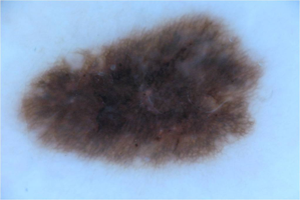

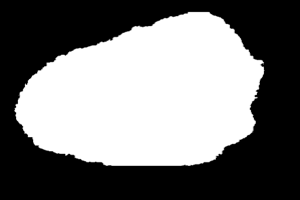

In [10]:
color_images = [Image.open(x).convert('RGB').resize((299,299)) for x in img_filepaths]
seg_images = [Image.open(x).resize((299,299)) for x in seg_filepaths]
display(color_images[0].resize((300,200)), seg_images[0].resize((300,200)))

For the non-segmented data arrays, convert to `numpy` format.

In [12]:
X_full_color = [np.array(x) for x in color_images]
print('Example shape for non-segmented, color image', X_full_color[0].shape)

Example shape for non-segmented, color image (299, 299, 3)


The segmented approach is a little different, and requires a previously-seen process for cutting the segmented lesion part from each image, and turning the rest of the frame black (i.e., 0-valued).

In [13]:
# lists of numpy arrays (data already present)
colors = [np.array(x) for x in color_images]
segs = [np.array(x) for x in seg_images]

# list for data needed
X_seg_color = []

for i in range(len(color_images)):
    # indexes of outer / black / 0-valued parts of segmentation files
    idxs = np.where(segs[i] == [0])

    # create copy of color/grey images and cut segmented portion, turn everything else 0/black
    c = colors[i].copy()
    c[idxs] = np.array([0,0,0])
    
    # store
    X_seg_color.append(c)

All image types. Note that the colors in the Black & White images are just plotting choices by `matplotlib` functions.

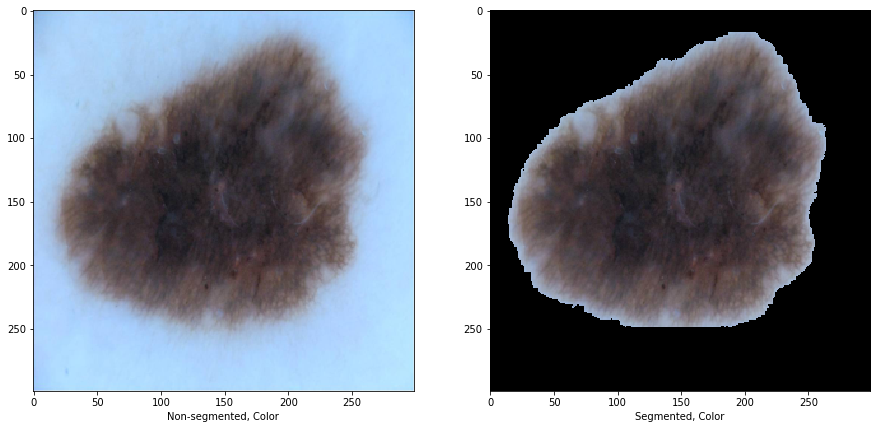

In [14]:
# plot
fix, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(X_full_color[0])
ax[1].imshow(X_seg_color[0])

# format 
ax[0].set_xlabel('Non-segmented, Color')
ax[1].set_xlabel('Segmented, Color')
plt.show()

Before the entire arrays can be made into `numpy` objects, all elements have to have the same shape. This requires looking ahead and recognizing the `InceptionV3` model which will be used, which has its own preprocessor that can be applied. Then the `numpy`-ification can be done.

In [15]:
X_fullcolor = [preprocess_input(x) for x in X_full_color]
X_segcolor = [preprocess_input(x) for x in X_seg_color]

Finally create two `numpy` arrays representing the complete "sets" of non-segmented and segmented images. These are the sets that will be split and passed into the models as batches.

In [16]:
X_nonseg = np.array(X_fullcolor)
X_seg = np.array(X_segcolor)
print(X_seg.shape, X_nonseg.shape)

(50, 299, 299, 3) (50, 299, 299, 3)


The targets must have a similar format, which can be achieved through one-hot encoding courtesy of `sklearn`.

In [17]:
le = LabelEncoder()
le.fit(targets)
y = le.transform(targets)

for i in range(3):
    print('Original target #%d is %s, transformed to %s' % (i, targets[i], y[i]))

Original target #0 is nevus, transformed to 1
Original target #1 is nevus, transformed to 1
Original target #2 is melanoma, transformed to 0


Shuffle all data at once, for good measure. The splitting for validation/testing can be done in the __Analysis__ section, as needed by the models.

In [18]:
Xseg, yseg = shuffle(X_seg, y)
Xnon, ynon = shuffle(X_nonseg, y)

# Analysis

## Compile Model

Building a model from scratch is unadvisable. Rely on transfer learning (using a deep architecture that is pre-built and pre-trained). InceptionV3 is arbitrarily chosen below because it is computationally faster (and loaded by Keras); it may be prudent to select other pre-trained models or build facial/skin recognition models in Keras based on literature. Freeze the original parameters of this model for now (keeping only the parameters in the added dense/pooling/output layers unfrozen). This ensures the model only learns to re-label in benign/malignant terms, and can be changed later to completely re-learn on this new skin data. Compile this model using some standard practices, and wrap in a resuable function.

In [31]:
def clean_model(num_classes=2):
    # initial model
    base_model = InceptionV3(weights='imagenet', input_shape=(299,299,3), include_top=False) 
    base_model.trainable = False

    # model on top
    inputs = keras.Input(shape=(299,299,3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    pred_layer = Dense(1)(x) if num_classes==2 else Dense(num_classes, activation='softmax')(x)

    # final model
    model = Model(inputs, pred_layer)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()])
    return model
    
mdl = clean_model()
mdl.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


## Train Model

Note that the learnable-layers of the loaded model were frozen. We are training the new partial model added on top of it (the part that tells it how to switch its outputs from ImageNet terms into benign/malignant terms. Train by passing the segmented data in. __For simplicity only 3 iterations are shown, but any value from 20, to 100, to 500 may be appropriate__. The cost comes in runtime and overfitting.

In [54]:
seg_history = mdl.fit(
    Xseg,
    yseg,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    validation_split = 0.2,
    epochs=3
)

Epoch 1/3
2/2 [==============================] - 5s 1s/step - loss: 0.5096 - binary_accuracy: 0.7500 - val_loss: 0.5475 - val_binary_accuracy: 0.6000
Epoch 2/3
2/2 [==============================] - 4s 1s/step - loss: 0.4940 - binary_accuracy: 0.8500 - val_loss: 0.5305 - val_binary_accuracy: 0.6000
Epoch 3/3
2/2 [==============================] - 4s 1s/step - loss: 0.4747 - binary_accuracy: 0.9000 - val_loss: 0.5175 - val_binary_accuracy: 0.6000


A similar process is done for the non-segmented data:

In [55]:
mdl2 = clean_model()
nonseg_history = mdl2.fit(
    Xseg,
    yseg,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    validation_split = 0.2,
    epochs=3
)

Epoch 1/3
2/2 [==============================] - 8s 2s/step - loss: 0.6439 - binary_accuracy: 0.5167 - val_loss: 0.5794 - val_binary_accuracy: 0.7000
Epoch 2/3
2/2 [==============================] - 4s 1s/step - loss: 0.6027 - binary_accuracy: 0.6250 - val_loss: 0.5901 - val_binary_accuracy: 0.7000
Epoch 3/3
2/2 [==============================] - 4s 1s/step - loss: 0.5872 - binary_accuracy: 0.6250 - val_loss: 0.6094 - val_binary_accuracy: 0.6000


## History & Performance

See how the models did visually:

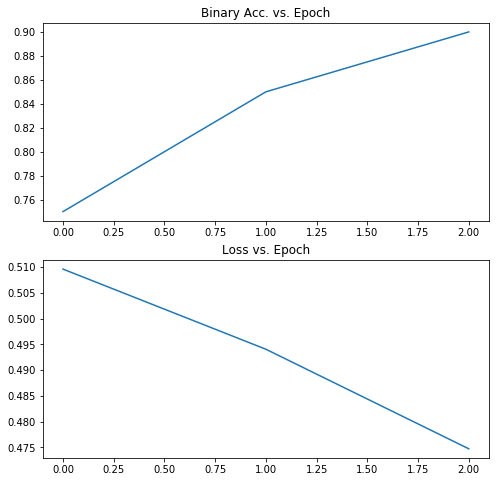

In [67]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(seg_history.history['binary_accuracy'])
ax[0].set_title('Binary Acc. vs. Epoch')
ax[1].plot(seg_history.history['loss'])
ax[1].set_title('Loss vs. Epoch')
plt.show()

For the non-segmented data.

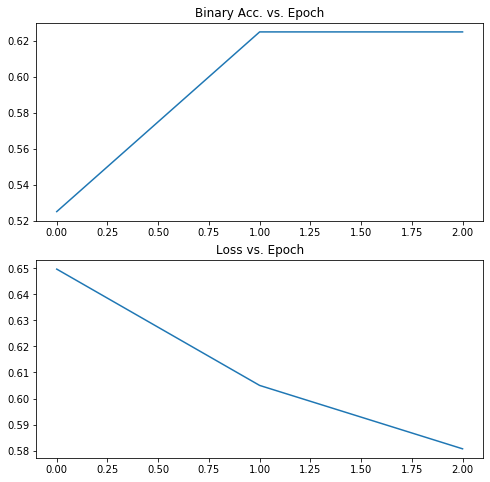

In [68]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(nonseg_history.history['binary_accuracy'])
ax[0].set_title('Binary Acc. vs. Epoch')
ax[1].plot(nonseg_history.history['loss'])
ax[1].set_title('Loss vs. Epoch')
plt.show()

Note that this is an exercise; realistically a test dataset would be pulled and set aside from these images. Then it can be determined whether the model learned __and__ whether it generalizes on new data.

## Fine-Tuning

If performance is insufficient, a next attempt can be fine-tuning. This involves using the trained models above, and unlocking __all__ layers for training. So not only is the final "benign/malignant" classifier trained, but the previously-ImageNet-based layers, too. This can cause moderate improvements but risks overfitting.

In [72]:
# un-freeze layers
for layer in mdl.layers:
    layer.trainable = True
    
for layer in mdl2.layers:
    layer.trainable = True
    
# re-compile for changes to take effect
mdl.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()])
mdl2.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=True), metrics=[BinaryAccuracy()])

Perform tuning.

In [73]:
seg_history = mdl.fit(
    Xseg,
    yseg,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    validation_split = 0.2,
    epochs=3
)

Epoch 1/3
2/2 [==============================] - 23s 5s/step - loss: 0.7540 - binary_accuracy: 0.6292 - val_loss: 85.5651 - val_binary_accuracy: 0.8000
Epoch 2/3
2/2 [==============================] - 17s 3s/step - loss: 115.2780 - binary_accuracy: 0.6292 - val_loss: 0.7636 - val_binary_accuracy: 0.2000
Epoch 3/3
2/2 [==============================] - 20s 3s/step - loss: 0.7445 - binary_accuracy: 0.2833 - val_loss: 0.6958 - val_binary_accuracy: 0.2000


In [74]:
nonseg_history = mdl2.fit(
    Xseg,
    yseg,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    validation_split = 0.2,
    epochs=3
)

Epoch 1/3
2/2 [==============================] - 24s 4s/step - loss: 0.7184 - binary_accuracy: 0.5854 - val_loss: 0.5153 - val_binary_accuracy: 0.8000
Epoch 2/3
2/2 [==============================] - 17s 3s/step - loss: 0.7541 - binary_accuracy: 0.5854 - val_loss: 0.5342 - val_binary_accuracy: 0.8000
Epoch 3/3
2/2 [==============================] - 18s 3s/step - loss: 1.0168 - binary_accuracy: 0.5417 - val_loss: 0.9700 - val_binary_accuracy: 0.8000


See results.

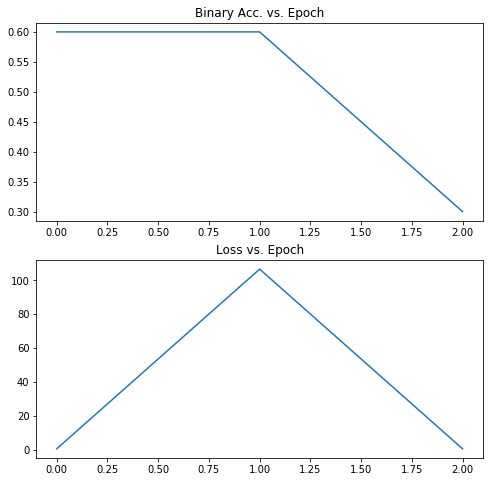

In [75]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(seg_history.history['binary_accuracy'])
ax[0].set_title('Binary Acc. vs. Epoch')
ax[1].plot(seg_history.history['loss'])
ax[1].set_title('Loss vs. Epoch')
plt.show()

For the non-segmented data:

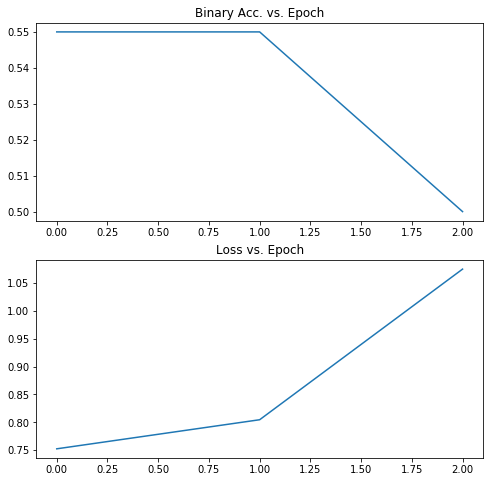

In [76]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(nonseg_history.history['binary_accuracy'])
ax[0].set_title('Binary Acc. vs. Epoch')
ax[1].plot(nonseg_history.history['loss'])
ax[1].set_title('Loss vs. Epoch')
plt.show()

## Optional Multi-Class Step

If binary classification is not of interest, maybe the individual diagnoses are more relevant. This begets a minor change to previous processes, all documented here. Start by loading the relevant features.

In [77]:
# extracting from json
dscs2 = [json.load(open(x, 'r'))['meta']['clinical'] for x in dsc_filepaths]
targets2 = [x['diagnosis'] for x in dscs2]

# sample output
for i in range(3):
    print('Data point #%d: %s' % (i, targets2[i]))

Data point #0: nevus
Data point #1: nevus
Data point #2: melanoma


Ready the targets.

In [78]:
# make response numeric
le = LabelEncoder()
le.fit(targets2)
y2 = le.transform(targets2)

# how many diagnoses
num_classes = len(le.classes_)
print('Found %d classes' % num_classes)

# output
for i in range(3):
    print('Original target #%d is %s, transformed to %s' % (i, targets2[i], y2[i]))

Found 2 classes
Original target #0 is nevus, transformed to 1
Original target #1 is nevus, transformed to 1
Original target #2 is melanoma, transformed to 0


Create the final X and y data. For simplicity, pick only one approach (segmented or non-segmented). The following uses the segmented X data.

In [79]:
Xseg, yseg2 = shuffle(X_seg, y2)
print(Xseg.shape, yseg2.shape)

(50, 299, 299, 3) (50,)


Create and train the model.

In [81]:
multi_mdl = clean_model()
multi_history = mdl.fit(
    Xseg,
    yseg2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    validation_split = 0.2,
    epochs=3
)

Epoch 1/3
2/2 [==============================] - 16s 3s/step - loss: 0.7669 - binary_accuracy: 0.6250 - val_loss: 0.6456 - val_binary_accuracy: 0.7000
Epoch 2/3
2/2 [==============================] - 19s 3s/step - loss: 0.5910 - binary_accuracy: 0.7250 - val_loss: 0.6481 - val_binary_accuracy: 0.3000
Epoch 3/3
2/2 [==============================] - 17s 3s/step - loss: 0.6442 - binary_accuracy: 0.3250 - val_loss: 0.6116 - val_binary_accuracy: 0.7000


View results.

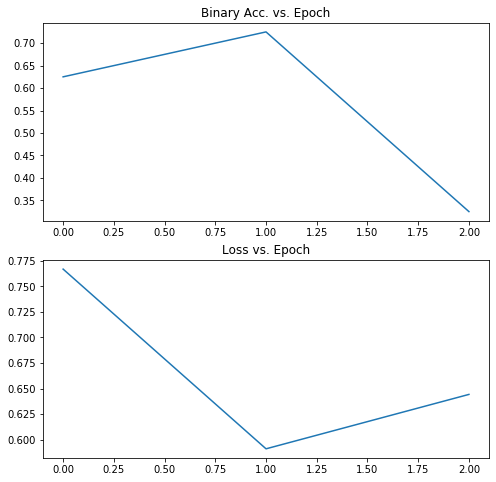

In [82]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(multi_history.history['binary_accuracy'])
ax[0].set_title('Binary Acc. vs. Epoch')
ax[1].plot(multi_history.history['loss'])
ax[1].set_title('Loss vs. Epoch')
plt.show()

If desired, repeat the fine-tuning step, as well.

# Discussion

*__Discuss the ability of deep models to learn skin lesion patterns.__* 

- Did models converge? 
- Was the accuracy sufficient? 
- Why might the results be as they are? 
- Can different optimizations (optimizers, callbacks, hyperparameter values) help?